<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-модулей" data-toc-modified-id="Импорт-модулей-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Импорт модулей</a></span></li><li><span><a href="#Настройки-окружения" data-toc-modified-id="Настройки-окружения-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Настройки окружения</a></span></li><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Чтение данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Подбор-параметров-выборки" data-toc-modified-id="Подбор-параметров-выборки-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подбор параметров выборки</a></span></li><li><span><a href="#Проверка-на-моделях" data-toc-modified-id="Проверка-на-моделях-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на моделях</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Результаты-исследования" data-toc-modified-id="Результаты-исследования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты исследования</a></span><ul class="toc-item"><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></li></ul></div>

<a id="top"></a>
# Предсказание количества заказов такси на следующий час
<p>
<div align="right"><b>Спринт 11 | Когорта ДС13 | Артур Урусов</b></div>

<blockquote>
Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
</blockquote>

## Подготовка

### Импорт модулей

In [1]:
import warnings
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

### Настройки окружения

In [2]:
STATE = 42
warnings.simplefilter('ignore')

### Чтение данных

Первым делом прочитаем файл и сохраним его в переменную. Так как у нас временной ряд, за индекс возьмём столбец с датами и временем:

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные довольно простые, в единственном столбце `num_orders` (*от англ. number of orders, «число заказов»*) хранится количество заказов.

Проверим, расположены ли временные метки в порядке возрастания:

In [4]:
df.index.is_monotonic

True

Отлично, значит можно ресемплировать данные по одному часу по сумме заказов.

In [5]:
df = df.resample('1H').sum()

## Анализ

Напишем функцию для построения графиков с дополнительными скользящими:

In [6]:
def rolling_plot(data):
    data.plot()
    data.rolling(24).mean().plot()
    data.rolling(24).std().plot()
    plt.legend(['normal', 'rolling mean', 'rolling std'])

Построим графики для всей последовательности, месяца, недели и суток:

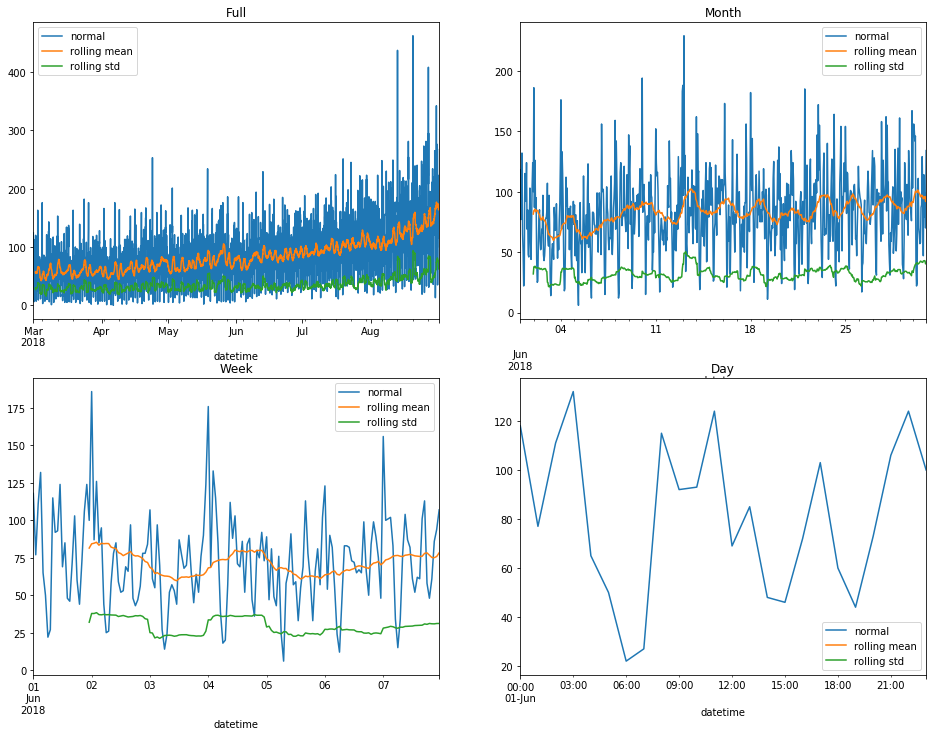

In [7]:
plt.figure(figsize=(16, 12))
plt.subplot(221)
rolling_plot(df['num_orders'])
plt.title('Full')
plt.subplot(222)
rolling_plot(df['num_orders']['2018-06-01':'2018-06-30'])
plt.title('Month')
plt.subplot(223)
rolling_plot(df['num_orders']['2018-06-01':'2018-06-07'])
plt.title('Week')
plt.subplot(224)
rolling_plot(df['num_orders']['2018-06-01':'2018-06-01'])
plt.title('Day')
plt.show()

Среднее значение на общем графике растёт со временем, что может свидетельствовать о положительном тренде и росте количества заказов. При этом стандартное отклонение довольно стабильно, хотя и начало увеличивать разброс ближе к концу графика. На графиках за месяц и неделю лучше видны последовательности в колебаниях, однако они всё ещё не так чётко прослеживаются, поэтому напишем функцию для разделения выборки на тренд, сезонные колебания и остатки: 

In [8]:
def decomposed_plot(data, labels=[]):
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    for el in data:
        el.trend.plot(ax=plt.gca())
    plt.legend(labels)
    plt.title('Trend')
    plt.subplot(312)
    for el in data:
        el.seasonal.plot(ax=plt.gca())
    plt.legend(labels)
    plt.title('Seasonality')
    plt.subplot(313)
    for el in data:
        el.resid.plot(ax=plt.gca())
    plt.legend(labels)
    plt.title('Residuals')
    plt.tight_layout()

Посмотрим на график в целом:

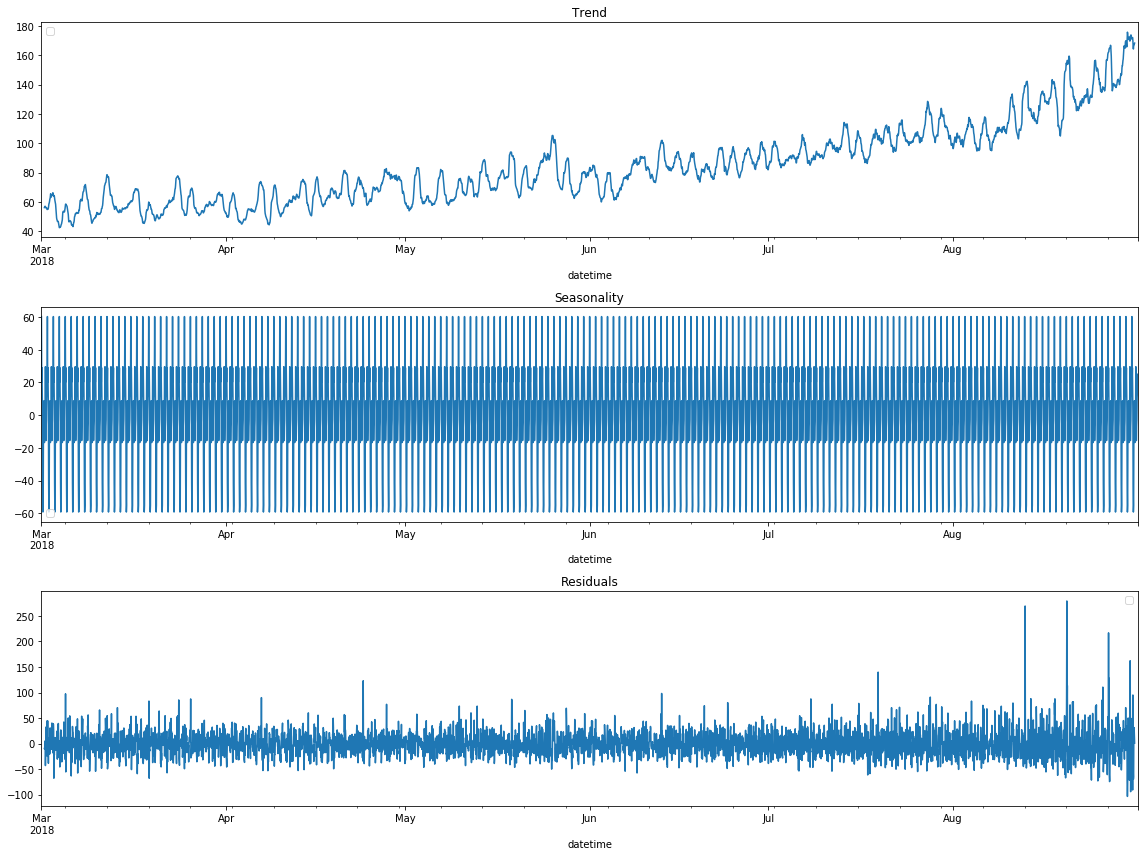

In [9]:
decomposed_plot([seasonal_decompose(df['num_orders'])])

Явно виден восходящий тренд, сезонность пока слиплась в кашу, а еще видны большие пики в остатках, которые вероятно и повлияли на увеличение разброса стандартного отклонения.

Посмотрим на график месяца:

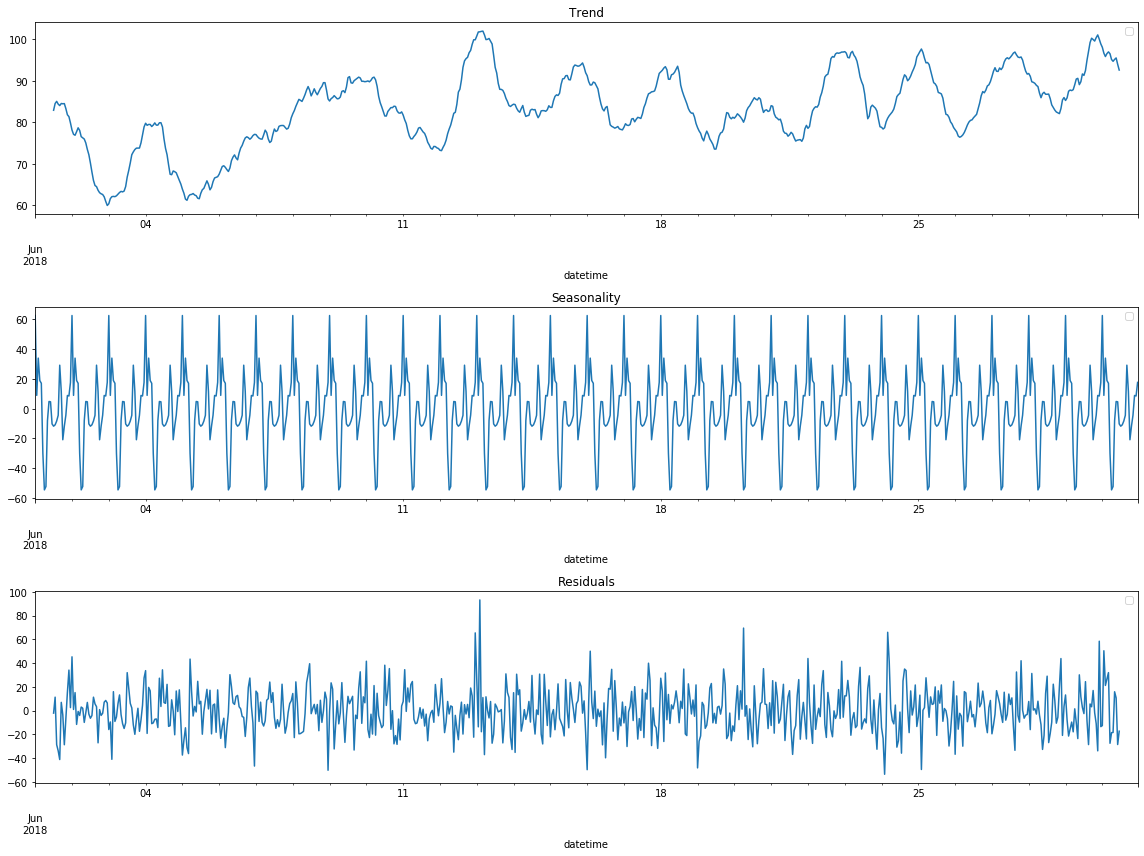

In [10]:
decomposed_plot([seasonal_decompose(df['num_orders']['2018-06-01':'2018-06-30'])])

На графике с масштабом в месяц не так хорошо прослеживается тренд, зато четко видны ежедневные «сезонные» колебания.

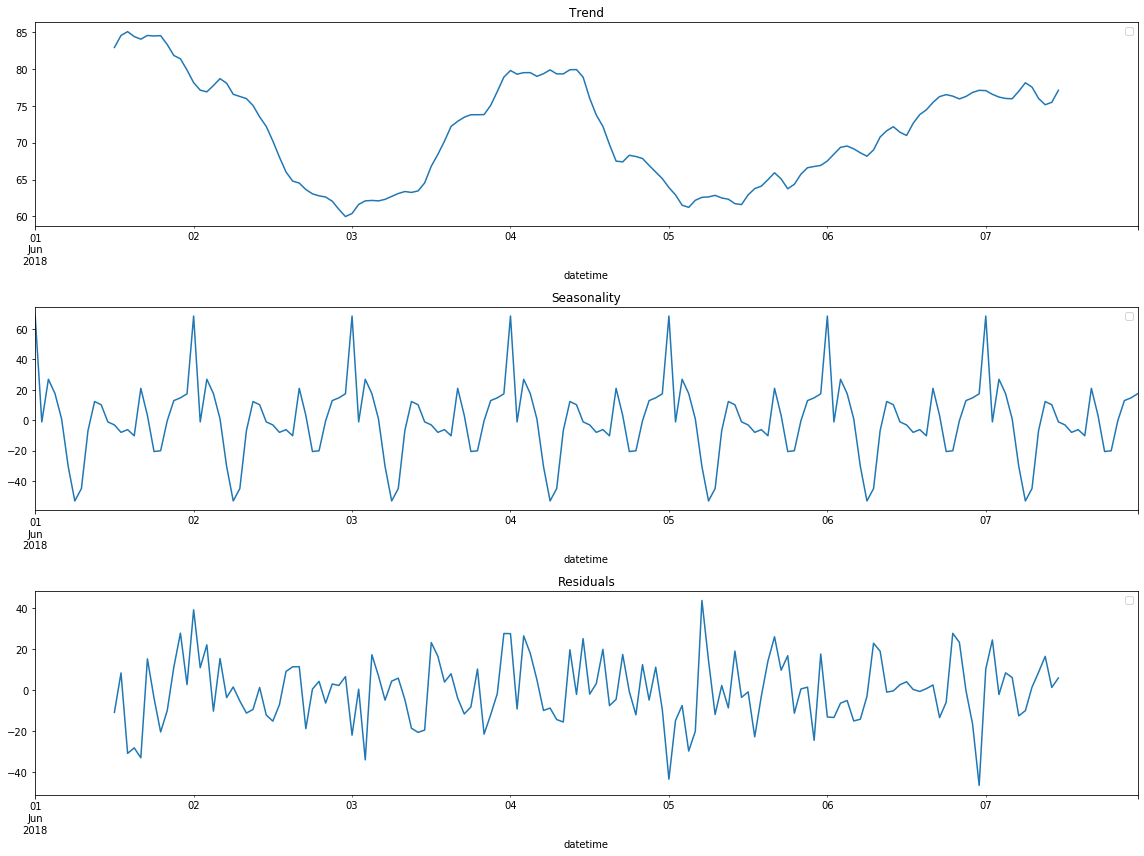

In [11]:
decomposed_plot([seasonal_decompose(df['num_orders']['2018-06-01':'2018-06-07'])])

На графике с масштабом в неделю «сезонность» можно отследить практически до часа, а вот линия тренда уже почти не даёт полезной информации.

## Обучение

### Подготовка

Напишем функции:
- `root_mean_squared_error` - для расчёта RMSE,
- `make_features` - для создания фич в выборке,
- `test_valid_split` - для разделения выборки на три части,
- `X_y_split` - для разделения выборки на фичи и таргет,
- `grid_random` - для выбора случайных значений из решетки параметров,
- `score_comparer` - для сравнения метрики текущей итерации с лучшей метрикой,
- `sample_tuning` - для подбора параметров в функцию `make_features`,
- `simple_grid_search` - для подбора гиперпараметров.

In [12]:
def root_mean_squared_error(y_true, y_pred):
    '''RMSE scorer function'''
    return np.sqrt(mean_squared_error(y_true, y_pred))


def make_features(data, features_parent, max_lag, rolling_mean_size):
    '''
    Function that extracts features (year, month, day, day of week and hour)
    from datetime values and counts rolling mean
    '''
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[features_parent].shift(lag)

    df['rolling_mean'] = df[features_parent].shift().rolling(rolling_mean_size).mean()
    
    return df


def test_valid_split(data, test_size=.1, valid_size=.1, verbose=True):
    '''Function that splits dataset into train, valid, test and train + test sets'''
    tralid, test = train_test_split(data, shuffle=False, test_size=test_size)
    train, valid = train_test_split(tralid, shuffle=False, test_size=valid_size)
    train, tralid = train.dropna(), tralid.dropna()
    
    # Verbosity prints sets info
    if verbose:
        print('Тренировочная выборка:', train.shape, train.index.min(), train.index.max())
        print('Валидационная выборка:', valid.shape, valid.index.min(), valid.index.max())
        print('Тренировочная + валидационная выборка:', tralid.shape, tralid.index.min(), tralid.index.max())
        print('Тестовая выборка:', test.shape, test.index.min(), test.index.max())
        print()
        
    return train, valid, tralid, test


def X_y_split(samples, target, verbose=True):
    '''Function that splits subsets into features and target'''
    X_y_data = []
    
    # Split every subset into features and target
    for sample in samples:
        X_y_data.extend([sample.drop(target, axis=1), sample[target]])
    
    # Verbosity prints subset shape
    if verbose:
        for el in X_y_data:
            print(el.shape, end=' ')
        print()
    
    return X_y_data


def grid_random(param_grid, random_state=None, random_sample=10):
    '''Function that generates (random) parameter sets from parameter grid'''
    keys, values = zip(*param_grid.items())
    params = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    # If number of samples is defined, make random grid subset
    if random_sample:
        random.seed(random_state)
        params = random.sample(params, random_sample)
        
    return params


def score_comparer(best_score, best_params, score, params, stopper, greater_is_better=False):
    '''Function that compares current score and best score'''
    if not greater_is_better:
        score *= -1       
        
    if score > best_score:
        best_score = score
        best_params = params
        stopper = 0
    else:
        stopper += 1  
        
    return best_score, best_params, stopper
    
def sample_tuning(
    estimator, param_grid, data, features_parent, target, 
    test_size=.1, valid_size=.1, scorer=root_mean_squared_error, random_state=None, random_sample=10, early_stop=5, 
    verbose=1, greater_is_better=False
):
    '''Function that finds best params for make_feature function'''
    best_score = float('inf') if greater_is_better else float('-inf')
    best_params = {}
    stopper = 0
    i = 1
    params = grid_random(param_grid, random_state, random_sample)
    
    # Fitting sets for every make_features() params in params grid
    for p in params:
        sample = make_features(data, features_parent, **p)
        train, valid, tralid, test = test_valid_split(sample, test_size, valid_size, verbose > 1)
        X_train, y_train, X_valid, y_valid = X_y_split([train, valid], target, verbose > 2)
        
        estimator.fit(X_train, y_train)
        score = scorer(y_valid, estimator.predict(X_valid))
        best_score, best_params, stopper = score_comparer(best_score, best_params, score, p, stopper, greater_is_better)
        
        # Verbosity prints RMSE score
        if verbose:
            print(f'{i}: RMSE: {score}')
            
        # Early stopping mechanics
        if early_stop and stopper >= early_stop:
            print('Early stopped')
            break
        i += 1
        
    print(f'Best score {-1 * best_score} with grid {best_params}\n')
    
    return best_params


def simple_grid_search(
    estimator, param_grid, X_train, y_train, X_valid, y_valid, 
    scorer=root_mean_squared_error, random_state=None, random_sample=10, early_stop=5, verbose=True,
    greater_is_better=False
):
    '''Function that finds best params from params grid'''
    best_score = float('inf') if greater_is_better else float('-inf')
    best_params = {}
    stopper = 0
    i = 1
    params = grid_random(param_grid, random_state, random_sample)
    
    # Searching for best model params in params grid 
    for p in params:
        est = estimator(**p, random_state=STATE)
        est.fit(X_train, y_train)
        score = scorer(y_valid, est.predict(X_valid))
        best_score, best_params, stopper = score_comparer(best_score, best_params, score, p, stopper, greater_is_better)
        
        # Verbosity prints RMSE score
        if verbose:
            print(f'{i}: RMSE: {score}')

        # Early stopping mechanics
        if early_stop and stopper >= early_stop:
            print('Early stopped')
            break
        i += 1
        
    print(f'Best score {-1 * best_score} with grid {best_params}\n')
    
    return best_params

Создадим выборку из данных с произвольными параметрами функции `make_features`:

In [13]:
data = make_features(df, 'num_orders', 6, 6)
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


Разделим выборку на три части и на фичи и таргет:

In [14]:
train, valid, tralid, test = test_valid_split(data)
X_train, y_train, X_valid, y_valid =  X_y_split([train, valid], 'num_orders')

Тренировочная выборка: (3570, 13) 2018-03-01 06:00:00 2018-07-27 23:00:00
Валидационная выборка: (398, 13) 2018-07-28 00:00:00 2018-08-13 13:00:00
Тренировочная + валидационная выборка: (3968, 13) 2018-03-01 06:00:00 2018-08-13 13:00:00
Тестовая выборка: (442, 13) 2018-08-13 14:00:00 2018-08-31 23:00:00

(3570, 12) (3570,) (398, 12) (398,) 


Теперь проверим простейшие модели.

Начнём с медианной:

In [15]:
pred_median = np.ones(valid.shape) * train['num_orders'].median()
print('RMSE:', root_mean_squared_error(valid, pred_median))

RMSE: 542.8477078939994


У медианной модели слишком большое значение **RMSE** чтобы принимать его во внимание, попробуем заполнение предыдущими значениями:

In [16]:
pred_ffill = valid.shift().fillna(train['num_orders'][-1])
print('RMSE:', root_mean_squared_error(valid, pred_ffill))

RMSE: 43.94458030485079


Такой вариант оказался намного точнее и даже смог опуститься ниже **48 RMSE**, правда, пока ещё не на тестовой выборке.

Теперь проверим регрессию:

In [17]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print('RMSE:', root_mean_squared_error(y_valid, lrm.predict(X_valid)))

RMSE: 40.80499093439751


Регрессия показала еще более низкое значение **RMSE**.

### Подбор параметров выборки

Теперь, с помощью регрессии подберём наиболее оптимальные параметры для функции `make_features`:

In [18]:
grid = dict(
    max_lag=list(range(1, 100, 10)),
    rolling_mean_size=list(range(1, 50, 2))
)

lrm = LinearRegression()
lrm_features_params = sample_tuning(
    estimator=lrm, 
    param_grid=grid, 
    data=df, 
    features_parent='num_orders', 
    target='num_orders',
    random_state=STATE
)

lrm_samples = dict()
lrm_samples['X_train'], lrm_samples['y_train'], \
lrm_samples['X_valid'], lrm_samples['y_valid'], \
lrm_samples['X_tralid'], lrm_samples['y_tralid'], \
lrm_samples['X_test'], lrm_samples['y_test'] = X_y_split(
    test_valid_split(make_features(df, 'num_orders', **lrm_features_params)), 'num_orders')

lrm.fit(lrm_samples['X_train'], lrm_samples['y_train'])
print('RMSE:', root_mean_squared_error(lrm_samples['y_valid'], lrm.predict(lrm_samples['X_valid'])))

1: RMSE: 31.723417190574036
2: RMSE: 40.341231877475735
3: RMSE: 41.087189110249255
4: RMSE: 31.543347322710993
5: RMSE: 38.688530782902035
6: RMSE: 34.88864567632086
7: RMSE: 38.79820437993663
8: RMSE: 40.02395960268014
9: RMSE: 31.543347322710858
10: RMSE: 40.341231877475735
Best score 31.543347322710858 with grid {'max_lag': 71, 'rolling_mean_size': 27}

Тренировочная выборка: (3505, 78) 2018-03-03 23:00:00 2018-07-27 23:00:00
Валидационная выборка: (398, 78) 2018-07-28 00:00:00 2018-08-13 13:00:00
Тренировочная + валидационная выборка: (3903, 78) 2018-03-03 23:00:00 2018-08-13 13:00:00
Тестовая выборка: (442, 78) 2018-08-13 14:00:00 2018-08-31 23:00:00

(3505, 77) (3505,) (398, 77) (398,) (3903, 77) (3903,) (442, 77) (442,) 
RMSE: 31.543347322710858


Получили наименьшее значение **RMSE 31.54** с параметрами `max_lag`: **71** и `rolling_mean_size`: **27**.

### Проверка на моделях

Подберём выборки для ненастроенных моделей:

In [19]:
dtm = DecisionTreeRegressor(random_state=STATE)
dtm_features_params = sample_tuning(
    estimator=dtm, 
    param_grid=grid, 
    data=df, 
    features_parent='num_orders', 
    target='num_orders',
    random_state=STATE
)

dtm_samples = dict()
dtm_samples['X_train'], dtm_samples['y_train'], \
dtm_samples['X_valid'], dtm_samples['y_valid'], \
dtm_samples['X_tralid'], dtm_samples['y_tralid'], \
dtm_samples['X_test'], dtm_samples['y_test'] = X_y_split(
    test_valid_split(make_features(df, 'num_orders', **dtm_features_params)), 'num_orders')

dtm.fit(dtm_samples['X_train'], dtm_samples['y_train'])
print('RMSE:', root_mean_squared_error(dtm_samples['y_valid'], dtm.predict(dtm_samples['X_valid'])))

1: RMSE: 43.85027632373988
2: RMSE: 41.134141390573575
3: RMSE: 42.39388170514881
4: RMSE: 45.19852912624347
5: RMSE: 46.50752357139346
6: RMSE: 42.53830670922906
7: RMSE: 41.06086914416659
8: RMSE: 40.534649239196874
9: RMSE: 44.429889436919424
10: RMSE: 38.899109289514435
Best score 38.899109289514435 with grid {'max_lag': 11, 'rolling_mean_size': 3}

Тренировочная выборка: (3565, 18) 2018-03-01 11:00:00 2018-07-27 23:00:00
Валидационная выборка: (398, 18) 2018-07-28 00:00:00 2018-08-13 13:00:00
Тренировочная + валидационная выборка: (3963, 18) 2018-03-01 11:00:00 2018-08-13 13:00:00
Тестовая выборка: (442, 18) 2018-08-13 14:00:00 2018-08-31 23:00:00

(3565, 17) (3565,) (398, 17) (398,) (3963, 17) (3963,) (442, 17) (442,) 
RMSE: 38.899109289514435


In [20]:
rfm = RandomForestRegressor(random_state=STATE)
rfm_features_params = sample_tuning(
    estimator=rfm, 
    param_grid=grid, 
    data=df, 
    features_parent='num_orders', 
    target='num_orders',
    random_state=STATE
)

rfm_samples = dict()
rfm_samples['X_train'], rfm_samples['y_train'], \
rfm_samples['X_valid'], rfm_samples['y_valid'], \
rfm_samples['X_tralid'], rfm_samples['y_tralid'], \
rfm_samples['X_test'], rfm_samples['y_test'] = X_y_split(
    test_valid_split(make_features(df, 'num_orders', **rfm_features_params)), 'num_orders')

rfm.fit(rfm_samples['X_train'], rfm_samples['y_train'])
print('RMSE:', root_mean_squared_error(rfm_samples['y_valid'], rfm.predict(rfm_samples['X_valid'])))

1: RMSE: 34.14113811163578
2: RMSE: 34.2088174445533
3: RMSE: 32.04420274633527
4: RMSE: 33.88613026181365
5: RMSE: 32.164370171708846
6: RMSE: 33.416137436963446
7: RMSE: 33.1803329924134
8: RMSE: 33.12088639480969
Early stopped
Best score 32.04420274633527 with grid {'max_lag': 1, 'rolling_mean_size': 13}

Тренировочная выборка: (3563, 8) 2018-03-01 13:00:00 2018-07-27 23:00:00
Валидационная выборка: (398, 8) 2018-07-28 00:00:00 2018-08-13 13:00:00
Тренировочная + валидационная выборка: (3961, 8) 2018-03-01 13:00:00 2018-08-13 13:00:00
Тестовая выборка: (442, 8) 2018-08-13 14:00:00 2018-08-31 23:00:00

(3563, 7) (3563,) (398, 7) (398,) (3961, 7) (3961,) (442, 7) (442,) 
RMSE: 32.04420274633527


In [21]:
cbm = CatBoostRegressor(iterations=100, silent=True, random_state=STATE)
cbm_features_params = sample_tuning(
    estimator=cbm, 
    param_grid=grid, 
    data=df, 
    features_parent='num_orders', 
    target='num_orders',
    random_state=STATE
)

cbm_samples = dict()
cbm_samples['X_train'], cbm_samples['y_train'], \
cbm_samples['X_valid'], cbm_samples['y_valid'], \
cbm_samples['X_tralid'], cbm_samples['y_tralid'], \
cbm_samples['X_test'], cbm_samples['y_test'] = X_y_split(
    test_valid_split(make_features(df, 'num_orders', **cbm_features_params)), 'num_orders')


cbm.fit(cbm_samples['X_train'], cbm_samples['y_train'])
print('RMSE:', root_mean_squared_error(cbm_samples['y_valid'], cbm.predict(cbm_samples['X_valid'])))

1: RMSE: 35.46119316480675
2: RMSE: 37.382517691377686
3: RMSE: 37.39352450231155
4: RMSE: 35.478823754081986
5: RMSE: 36.87559741666577
6: RMSE: 36.888628863463225
Early stopped
Best score 35.46119316480675 with grid {'max_lag': 61, 'rolling_mean_size': 27}

Тренировочная выборка: (3515, 68) 2018-03-03 13:00:00 2018-07-27 23:00:00
Валидационная выборка: (398, 68) 2018-07-28 00:00:00 2018-08-13 13:00:00
Тренировочная + валидационная выборка: (3913, 68) 2018-03-03 13:00:00 2018-08-13 13:00:00
Тестовая выборка: (442, 68) 2018-08-13 14:00:00 2018-08-31 23:00:00

(3515, 67) (3515,) (398, 67) (398,) (3913, 67) (3913,) (442, 67) (442,) 
RMSE: 35.46119316480675


Ненастроенные модели показали результат даже слабее линейной регрессии, поэтому подберём для них гиперпараметры.

### Подбор гиперпараметров

In [22]:
dtm_grid = {
    'criterion': ['mse', 'friedman_mse'],
    'min_samples_split': [10, 20, 40],
    'max_depth': [2, 6, 8],
    'min_samples_leaf': [20, 40, 100],
    'max_leaf_nodes': [5, 20, 100],
}
dtm_best_params = simple_grid_search(
    estimator=DecisionTreeRegressor, 
    param_grid=dtm_grid, 
    X_train=dtm_samples['X_train'],
    y_train=dtm_samples['y_train'],
    X_valid=dtm_samples['X_valid'],
    y_valid=dtm_samples['y_valid'],
    random_state=STATE
)

1: RMSE: 49.51768891378067
2: RMSE: 49.51768891378067
3: RMSE: 39.95534807974459
4: RMSE: 49.51768891378067
5: RMSE: 49.51768891378067
6: RMSE: 49.51768891378067
7: RMSE: 38.9928917227219
8: RMSE: 49.51768891378067
9: RMSE: 36.21888431674092
10: RMSE: 39.95534807974459
Best score 36.21888431674092 with grid {'criterion': 'mse', 'min_samples_split': 10, 'max_depth': 8, 'min_samples_leaf': 40, 'max_leaf_nodes': 20}



In [23]:
rfm_grid = {
    'bootstrap': [True, False],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300],
}
rfm_best_params = simple_grid_search(
    estimator=RandomForestRegressor, 
    param_grid=rfm_grid, 
    X_train=rfm_samples['X_train'],
    y_train=rfm_samples['y_train'],
    X_valid=rfm_samples['X_valid'],
    y_valid=rfm_samples['y_valid'],
    random_state=STATE
)

1: RMSE: 36.356704264850045
2: RMSE: 36.34297152485079
3: RMSE: 34.22778301742388
4: RMSE: 36.68910244656258
5: RMSE: 36.312132494945914
6: RMSE: 36.68910244656258
7: RMSE: 34.23819400835344
8: RMSE: 35.59603613788545
Early stopped
Best score 34.22778301742388 with grid {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}



In [24]:
cbm_grid = {
    'silent': [True],
    'learning_rate': [.01, .05, .1, .5],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [30, 50, 100],
}
cbm_best_params = simple_grid_search(
    estimator=CatBoostRegressor,
    param_grid=cbm_grid, 
    X_train=cbm_samples['X_train'],
    y_train=cbm_samples['y_train'],
    X_valid=cbm_samples['X_valid'],
    y_valid=cbm_samples['y_valid'],
    random_state=STATE
)

1: RMSE: 34.02372348257788
2: RMSE: 49.66167745339374
3: RMSE: 52.72262657823597
4: RMSE: 33.22287010297781
5: RMSE: 37.70530988371732
6: RMSE: 34.32977492222027
7: RMSE: 53.18265752351768
8: RMSE: 43.523318141932
9: RMSE: 31.711606371095307
10: RMSE: 44.2415385812653
Best score 31.711606371095307 with grid {'silent': True, 'learning_rate': 0.5, 'depth': 4, 'l2_leaf_reg': 5, 'iterations': 100}



Лучшими параметрами оказались:
- для решающего дерева: 

`Best score 36.21888431674092 
 with grid {'criterion': 'mse', 'min_samples_split': 10, 'max_depth': 8, 'min_samples_leaf': 40, 'max_leaf_nodes': 20}`
- для случайного леса: 

`Best score 34.22778301742388 
 with grid {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}`
- для Catboost: 

`Best score 31.711606371095307 
 with grid {'silent': True, 'learning_rate': 0.5, 'depth': 4, 'l2_leaf_reg': 5, 'iterations': 100}`

Теперь проверим модели на тестовой выборке.

## Тестирование

Для тестирования возьмём:
- предсказание по предыдущим значениям,
- линейную регрессию,
- решающее дерево,
- случайный лес,
- Catboost.

In [25]:
pred_ffill = lrm_samples['y_test'].shift().fillna(lrm_samples['y_tralid'][-1])
print('RMSE:', root_mean_squared_error(lrm_samples['y_test'], pred_ffill))

RMSE: 58.856486242815066


In [26]:
lrm = LinearRegression()
lrm.fit(lrm_samples['X_tralid'], lrm_samples['y_tralid'])
print('RMSE:', root_mean_squared_error(lrm_samples['y_test'], lrm.predict(lrm_samples['X_test'])))

RMSE: 43.56529303541636


In [27]:
dtm = DecisionTreeRegressor(**dtm_best_params, random_state=STATE)
dtm.fit(dtm_samples['X_tralid'], dtm_samples['y_tralid'])
print('RMSE:', root_mean_squared_error(cbm_samples['y_test'], dtm.predict(dtm_samples['X_test'])))

RMSE: 53.50350404511937


In [28]:
rfm = RandomForestRegressor(**rfm_best_params, random_state=STATE)
rfm.fit(rfm_samples['X_tralid'], rfm_samples['y_tralid'])
print('RMSE:', root_mean_squared_error(cbm_samples['y_test'], rfm.predict(rfm_samples['X_test'])))

RMSE: 46.22884660595553


In [29]:
cbm = CatBoostRegressor(**cbm_best_params, random_state=STATE)
cbm.fit(cbm_samples['X_tralid'], cbm_samples['y_tralid'])
print('RMSE:', root_mean_squared_error(cbm_samples['y_test'], cbm.predict(cbm_samples['X_test'])))

RMSE: 42.33596008451666


Получилось, что результата ниже **48 RMSE** достигли три модели: линейная регрессия, случайный лес и Catboost. Лучшие результаты у линейной регрессии и у Catboost. То есть параметры для моделей или параметры для выборки мы подобрали недостаточно хорошо.

Посмотрим на графике как различаются предсказания Catboost и настоящие значения:

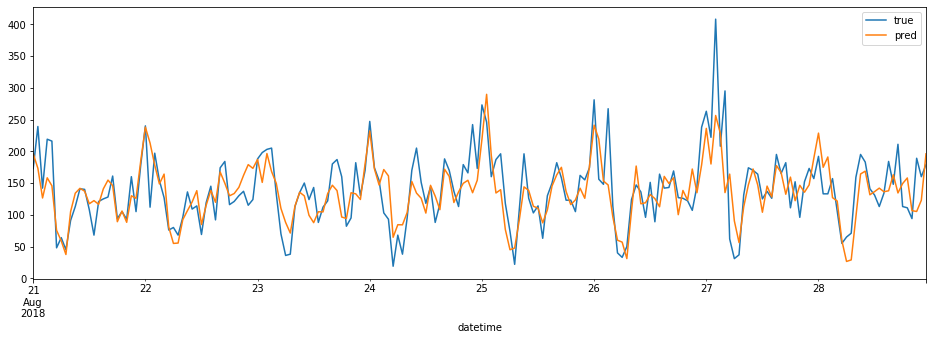

In [30]:
y_test = cbm_samples['y_test']
y_pred = pd.Series(cbm.predict(cbm_samples['X_test']), index=cbm_samples['y_test'].index)

plt.figure(figsize=(16, 5))
y_test['2018-08-21':'2018-08-28'].plot()
y_pred['2018-08-21':'2018-08-28'].plot()
plt.legend(['true', 'pred'])
plt.show()

Видно, что в целом графики очень похожи, однако некоторые пики сильно не совпадают. Попробуем разложить получившиеся результаты:

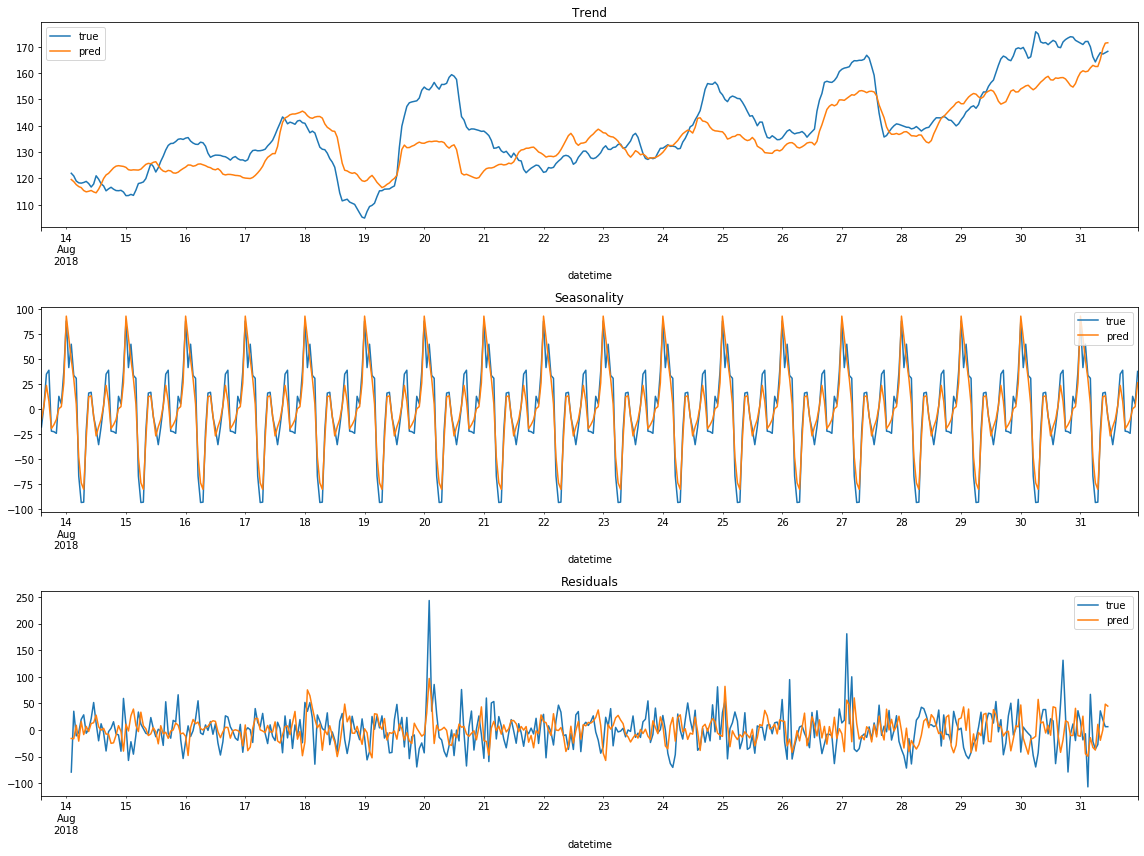

In [31]:
true_decomposed = seasonal_decompose(y_test)
pred_decomposed = seasonal_decompose(y_pred)
decomposed_plot([true_decomposed, pred_decomposed], labels=['true', 'pred'])

Модель почти идеально попадает в «сезонные» колебания, с трендом угадывает общие направления, но не так точна, и ожидаемо плоха с предсказанием остатков.

## Результаты исследования

### Общие выводы

В исследовании мы обучали модели машинного обучения для предсказания количества заказов такси.

Для работы нам предоставили датасет с отметками времени и 1 целевым признаком.

Сначала произвели ресемплирование датасета по 1 часу.

Затем мы провели небольшой анализ.

Далее мы написали функции для расчёта RMSE, разделения выборок, подбора параметров выборок и гиперпараметров моделей, с их помощью мы оценили медианный метод, метод заполнения предыдущими значениями, линейную регрессию, решающее дерево, случайный лес и Catboost. На этом шаге лучше всего показала себя линейная регрессия.

После этого мы использовали функцию для подбора гиперпараметров и подобрали гиперпараметры для моделей.

В конце проверили все модели на тестовой выборке, требуемый результат ниже 48 RMSE показали только три модели: Catboost, линейная регрессия и случайный лес. При этом регрессия почти не уступила Catboost.

Заодно мы разобрали какие части временных рядов лучше получилось предсказать: сезонность практически совпала, тренд подобен в целом, а вот остатки получились не очень тоными.

В итоге, для предсказания количества заказов можно брать как  Catboost так и линейную регрессию. Однако, вероятно, при более тщательном подборе параметров Catboost сможет сделать еще более точные предсказания.

### Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48